<a href="https://colab.research.google.com/github/amruthaduvvuri/Workplace-Mental-Health-Disclosure-Analysis/blob/main/Workplace_Mental_Health_%26_Disclosure_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Workplace resources and willingness to speak out:
a study of Mental Health in Tech by the Real Ricardo

The data used in this notebook was downloaded from Kaggle. The source of the data was a survey done in 2014 by OSMI, a non-profit organization dedicated to raising awareness, educating, and providing resources to support mental wellness in the tech and open source communities.

In [1]:
# classic importing of libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# choosing color palette
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

1. Data Cleaning

In [2]:
# loading data into pandas dataframe and exploring columns and first rows
survey = pd.read_csv('survey.csv')
survey.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [3]:
# renaming columns to have all lowercase
survey.columns = [col.lower() for col in survey.columns]

# looking at dtypes, we can see all of them are pandas objects except for age that is int.
print(survey.dtypes)

timestamp                    object
age                           int64
gender                       object
country                      object
state                        object
self_employed                object
family_history               object
treatment                    object
work_interfere               object
no_employees                 object
remote_work                  object
tech_company                 object
benefits                     object
care_options                 object
wellness_program             object
seek_help                    object
anonymity                    object
leave                        object
mental_health_consequence    object
phys_health_consequence      object
coworkers                    object
supervisor                   object
mental_health_interview      object
phys_health_interview        object
mental_vs_physical           object
obs_consequence              object
comments                     object
dtype: object


In [4]:
survey.drop(['timestamp', 'state', 'comments', 'country'], axis= 1, inplace= True)

In [5]:
# after finding some weird responses in the age column ('such as 99999999 and -1729')
# i decided to only include 'valid' numbers for age
survey['age'] = survey['age'].apply(lambda x: x if 0 < x < 100 else np.nan)

In [6]:
# gender is one big mess of data but I believe in myself.
# first lower case and strip eveything to decrease options
survey['gender'] = survey['gender'].apply(lambda x: x.lower().strip())

# based on the replies made these lists manually, I hope to not offend anyone.
male = ['male', 'm', 'make', 'cis male', 'man', 'cis man', 'msle', 'malr', 'mail', 'maile', 'something kinda male?', 'ostensibly male, unsure what that really means', 'male-ish', 'guy (-ish) ^_^', 'mal', 'male (cis)']
female = ['female', 'f', 'woman', 'female (cis)', 'cis-female/femme', 'femake', 'cis female', 'femail']

def regender(gender_input):

    """
    Input: a string about gender
    Output: male, female or other depending on our dictionary

    """
    if gender_input in male:
        return 'male'
    elif gender_input in female:
        return 'female'
    else:
        return 'other'

survey['gender'] = survey['gender'].apply(regender)

# check our final results
survey.gender.value_counts(dropna= False)

,count
gender,
male,994
female,247
other,18


In [7]:
# checking for nans
nan_cols = []
for col in survey.columns:
    if survey[col].isnull().sum():
        print(col + ' (%): ' + str(sum(survey[col].isnull())/len(survey)))
        nan_cols += [col]

# nans are present in the self-employed column and in the work_interfere column.
# at most there are 20% of values with nans so we'll replace with 'Don't know'
for col in nan_cols:
    survey[col].fillna("Don't know", inplace= True)

# i'm just gonna drop the rows without age.
survey = survey[survey.age != "Don't know"]

# in the context of our questions we need to drop everyone who is self-employed
print(survey['self_employed'].value_counts())
survey.loc[survey['self_employed'] == 'Yes'] = np.nan
survey.dropna(inplace=True)

age (%): 0.003971405877680699
self_employed (%): 0.014297061159650517
work_interfere (%): 0.2096902303415409
self_employed
No            1092
Yes            144
Don't know      18
Name: count, dtype: int64


/tmp/ipython-input-763136699.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survey[col].fillna("Don't know", inplace= True)
/tmp/ipython-input-763136699.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Don't know' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  survey[col].fillna("Don't know", inplace= True)


In [8]:
# getting unique answers for every column
exclude = ['age']
possible_answers = {col:[i for i in survey[col].unique()] for col in survey.columns if col not in exclude}
possible_answers

{'gender': ['female', 'male', 'other'],
 'self_employed': ["Don't know", 'No'],
 'family_history': ['No', 'Yes'],
 'treatment': ['Yes', 'No'],
 'work_interfere': ['Often', 'Rarely', 'Never', 'Sometimes', "Don't know"],
 'no_employees': ['6-25',
  'More than 1000',
  '26-100',
  '100-500',
  '1-5',
  '500-1000'],
 'remote_work': ['No', 'Yes'],
 'tech_company': ['Yes', 'No'],
 'benefits': ['Yes', "Don't know", 'No'],
 'care_options': ['Not sure', 'No', 'Yes'],
 'wellness_program': ['No', "Don't know", 'Yes'],
 'seek_help': ['Yes', "Don't know", 'No'],
 'anonymity': ['Yes', "Don't know", 'No'],
 'leave': ['Somewhat easy',
  "Don't know",
  'Somewhat difficult',
  'Very difficult',
  'Very easy'],
 'mental_health_consequence': ['No', 'Maybe', 'Yes'],
 'phys_health_consequence': ['No', 'Yes', 'Maybe'],
 'coworkers': ['Some of them', 'No', 'Yes'],
 'supervisor': ['Yes', 'No', 'Some of them'],
 'mental_health_interview': ['No', 'Yes', 'Maybe'],
 'phys_health_interview': ['Maybe', 'No', 'Yes']

In [9]:
def replace_uncertainty(survey_answer):
    """
    Uniformizes all uncertain answers.
    Input: half-answer (string)
    Output: 'Don't know'

    """

    uncertainty = ['Maybe', 'Some of them', 'Not sure']
    if survey_answer in uncertainty:
        return "Don't know"
    else:
        return survey_answer

# apply function to all columns
for col in survey.columns:
    survey[col] = survey[col].apply(replace_uncertainty)

In [10]:
survey['care_options'] = survey['care_options'].replace(to_replace="Don't know", value= 'No')
survey['care_options'].value_counts()

,count
care_options,
No,730
Yes,380


2. Exploratory Data Analysis

In [11]:

# create a dictionary to map out all the answers in the survey
encoding_dict = {'No': -1, "Don't know": 0, 'Yes': 1,
                 'Never': -2, 'Rarely': -1, 'Sometimes': 1, 'Often': 2,
                 'Very difficult': -2, 'Somewhat difficult': -1, 'Somewhat easy': 1, 'Very easy': 2,
                 '1-5': 0, '6-25': 1, '26-100': 2, '100-500': 3, '500-1000': 4, 'More than 1000': 5,
                 'male': -1, 'other': 0, 'female': 1}

In [12]:
# made a copy just to check values
survey_coded = survey.copy()

# for each column except the ones not excluded change the values in our dictionary
for col in survey_coded.columns:
    if col not in exclude:
        survey_coded[col] = survey_coded[col].map(encoding_dict)

In [13]:
# let's take a look at our answer-encoded dataframe.
survey_coded

,age,gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37.0,1,0,-1,1,2,1,-1,1,1,...,1,1,-1,-1,0,1,-1,0,1,-1
1,44.0,-1,0,-1,-1,-1,5,-1,-1,0,...,0,0,0,-1,-1,-1,-1,-1,0,-1
2,32.0,-1,0,-1,-1,-1,1,-1,1,-1,...,0,-1,-1,-1,1,1,1,1,-1,-1
3,31.0,-1,0,1,1,2,2,-1,1,-1,...,-1,-1,1,1,0,-1,0,0,-1,1
4,31.0,-1,0,-1,-1,-2,3,1,1,1,...,0,0,-1,-1,0,1,1,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,26.0,-1,-1,-1,1,0,2,-1,1,-1,...,0,1,-1,-1,0,0,-1,-1,0,-1
1255,32.0,-1,-1,1,1,2,2,1,1,1,...,1,-1,-1,-1,0,1,-1,-1,1,-1
1256,34.0,-1,-1,1,1,1,5,-1,1,1,...,0,-1,1,1,-1,-1,-1,-1,-1,-1
1257,46.0,1,-1,-1,-1,0,3,1,1,-1,...,0,0,1,-1,-1,-1,-1,-1,-1,-1


In [14]:

# make the correlation matrix
correlation = survey_coded.corr()

<Axes: >

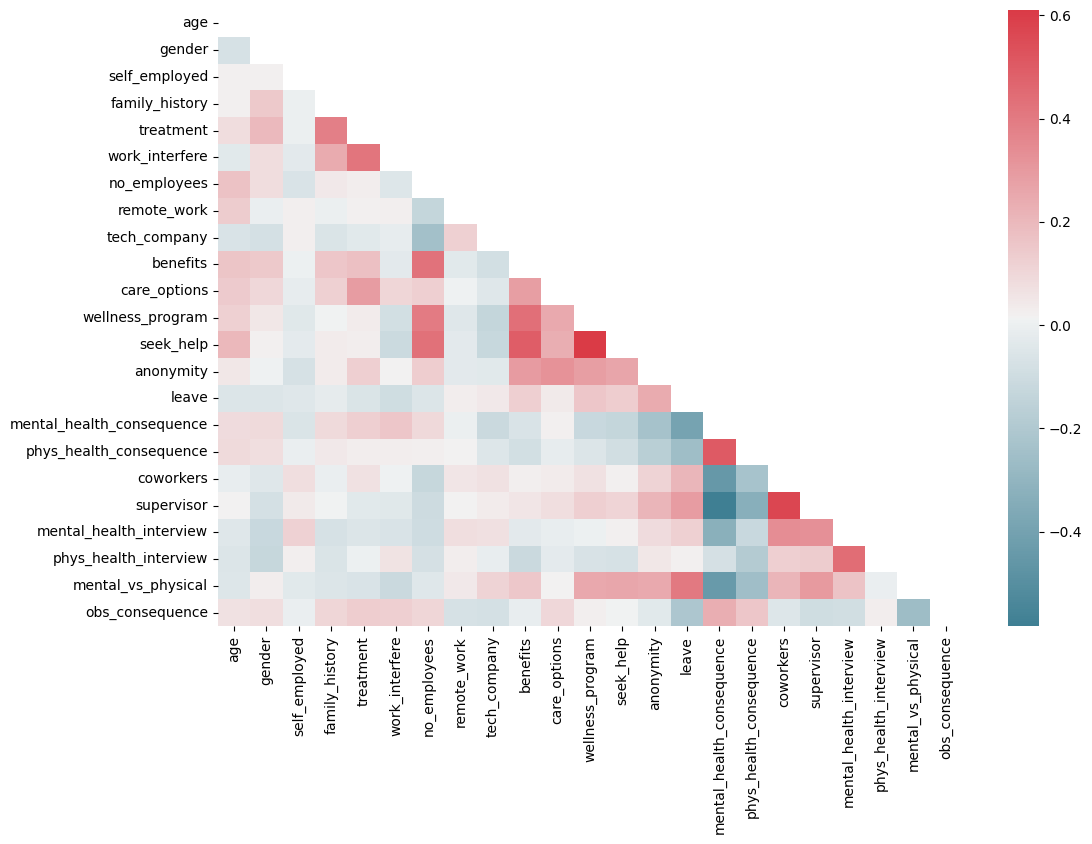

In [15]:
# making a mask to only show half the table cause its duplicated.
mask = np.triu(np.ones_like(correlation, dtype=np.bool))

# choosing colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, cmap=cmap, mask=mask, annot= False)

3. Hypothesis-driven analysis

In [16]:
# define columns to combine
workplace_resources = ['benefits',
                      'wellness_program',
                      'anonymity',
                      'seek_help',
                      'leave']

willingness = ['coworkers',
               'supervisor',
               'mental_health_interview']

# add columns together
survey_coded['workplace_resources'] = survey_coded.benefits + survey_coded.wellness_program + survey_coded.seek_help + survey_coded.leave + survey_coded.anonymity
survey_coded['willingness'] = survey_coded.coworkers + survey_coded.supervisor + survey_coded.mental_health_interview


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def pretty_histogram(df, column, xlabel, bins=10, save=False):
    plt.figure(figsize=(7, 5))
    sns.histplot(df[column].dropna(), bins=bins)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title(f"Distribution of {xlabel}")
    plt.tight_layout()
    plt.show()

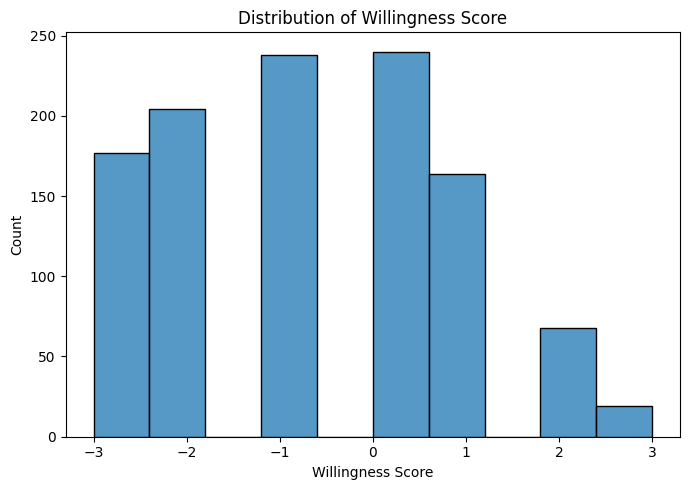

In [21]:
# make a histogram for our newly created 'Willingness' variable.
pretty_histogram(survey_coded, 'willingness', 'Willingness Score', save= False)

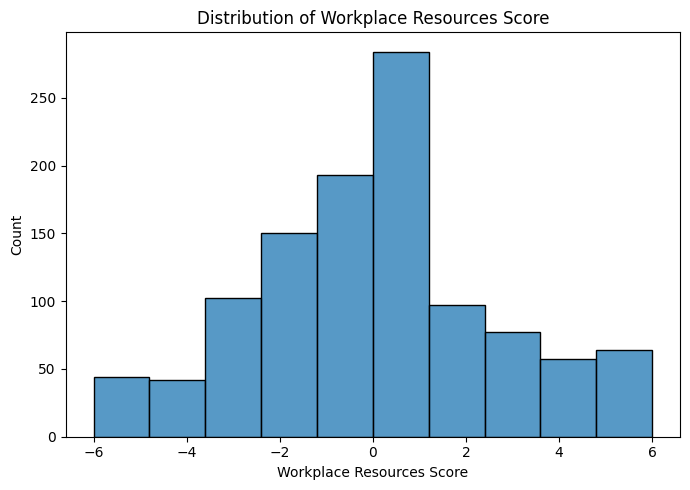

In [22]:
# make a histogram for our newly created 'Workplace Resources' variable
pretty_histogram(survey_coded, 'workplace_resources', 'Workplace Resources Score', save= True)


In [23]:
# interestingly to check the proportion of people aware of services I needed to recode the values in the
# care options column from 'No' = -1 to 'No' = 0
survey_coded['care_options'].replace(to_replace=-1, value=0, inplace= True)
survey_coded.pivot_table(index=['workplace_resources'], values=['care_options'], aggfunc= lambda x: sum(x)/len(x))


/tmp/ipython-input-203459699.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  survey_coded['care_options'].replace(to_replace=-1, value=0, inplace= True)


,care_options
workplace_resources,
-6,0.400000
-5,0.441176
-4,0.333333
-3,0.215686
-2,0.180000
-1,0.176166
0,0.252809
1,0.377358
2,0.432990


/tmp/ipython-input-3590869027.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bars = sns.barplot(


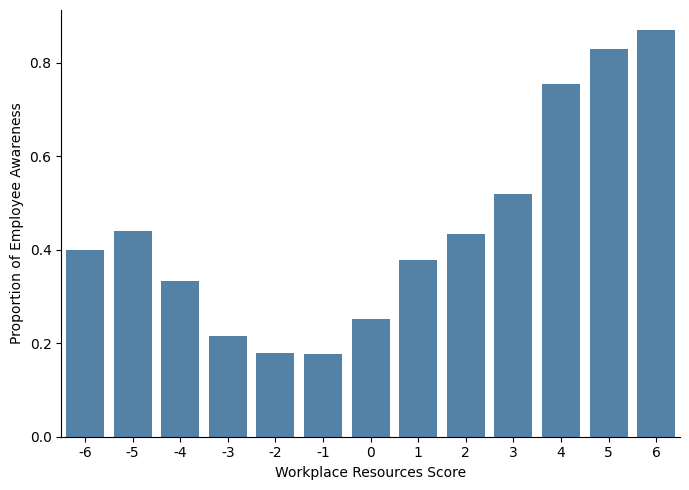

In [25]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# ensure output directory exists
os.makedirs("figures", exist_ok=True)

label = "Workplace Resources Score"

plt.figure(figsize=(7, 5))

bars = sns.barplot(
    x="workplace_resources",
    y="care_options",
    data=survey_coded,
    estimator="mean",   # proportion (mean of binary variable)
    ci=None,
    color="steelblue"   # avoids undefined palette errors
)

bars.set(
    xlabel=label,
    ylabel="Proportion of Employee Awareness"
)

sns.despine()
plt.tight_layout()
plt.savefig("figures/resources_and_awareness.png")
plt.show()

In [26]:
# group by variable of interest, create a label and rename columns
family_data = survey_coded.groupby('family_history').agg({'willingness':'mean'}).reset_index()
family_data['label'] = ['Family History']*len(family_data)
family_data.rename(columns= {'family_history':'Answer'}, inplace=True)

treatment_data = survey_coded.groupby('treatment').agg({'willingness':'mean'}).reset_index()
treatment_data['label'] = ['Treatment']*len(treatment_data)
treatment_data.rename(columns= {'treatment':'Answer'}, inplace=True)

willingness_variables = pd.concat([family_data, treatment_data], axis=0)
willingness_variables.Answer.replace(to_replace=-1, value='No', inplace=True)
willingness_variables.Answer.replace(to_replace=1, value='Yes', inplace=True)


/tmp/ipython-input-682374136.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  willingness_variables.Answer.replace(to_replace=-1, value='No', inplace=True)


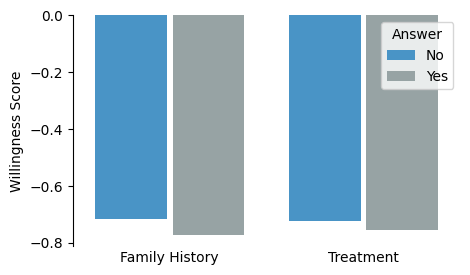

In [27]:
# making a category bar plot
fig, ax = plt.subplots(figsize=(5, 3))

bars= sns.barplot(x="label", y="willingness", hue="Answer",
            palette= sns.color_palette(flatui[1:3]),
            data=willingness_variables)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


change_width(ax, .37)
sns.despine(bottom=True)
bars.set(xlabel= '', ylabel= 'Willingness Score')
bars.tick_params(axis='x', which='both', length=0)
figure = bars.get_figure()
figure.savefig('figures/history_treatment_willingness.png')

/tmp/ipython-input-797012715.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.75}` instead.

  bars = sns.barplot(x= 'work_interfere', y= 'willingness', data= survey_coded, color= flatui[-1], errwidth=0.75)
/tmp/ipython-input-797012715.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bars.set(xlabel= xlabel, ylabel= ylabel, xticklabels=['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'])
/tmp/ipython-input-797012715.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bars.set_xticklabels(['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'], rotation=30)


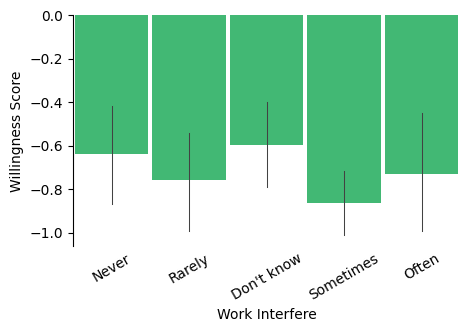

In [28]:
xlabel = 'Work Interfere'
ylabel = 'Willingness Score'

fig, ax = plt.subplots(figsize=(5, 3))
bars = sns.barplot(x= 'work_interfere', y= 'willingness', data= survey_coded, color= flatui[-1], errwidth=0.75)

bars.set(xlabel= xlabel, ylabel= ylabel, xticklabels=['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'])
bars.set_xticklabels(['Never', 'Rarely', "Don't know", 'Sometimes', 'Often'], rotation=30)
bars.set()
sns.despine(bottom= True)
change_width(ax, .95)
bars.tick_params(axis='x', which='both', length=0)

figure = bars.get_figure()
figure.savefig('figures/work_interfere_willingness.png')

In [29]:
# I also did this analysis for gender but I find it slightly less interesting.
gender_willingness = survey_coded.groupby('gender').agg({'willingness':'mean'})
gender_willingness

,willingness
gender,
-1,-0.659404
0,-0.615385
1,-1.053333


contrary to expected, it seems that women are less likely to open up about mental health. However, upon further thinking, this might make sense if we consider that tech is a male-dominated industry where perhaps climbing up the ladder as a woman is significantly harder. in that case, they would be much more scared to bring up these issues and make their lives ever harder?

In [30]:
# to reach the answer to our main question
willingness_treatment = survey_coded.groupby('workplace_resources').agg({'willingness':'mean'})
willingness_treatment

,willingness
workplace_resources,
-6,-2.600000
-5,-1.323529
-4,-1.000000
-3,-1.333333
-2,-0.820000
-1,-0.782383
0,-0.752809
1,-0.641509
2,-0.453608


/tmp/ipython-input-1621852444.py:6: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 0.75}` instead.

  bars = sns.barplot(x='workplace_resources', y='willingness', data= survey_coded,


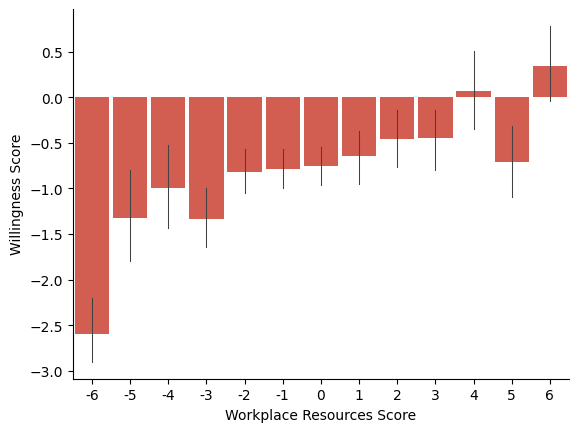

In [31]:
# create a bar plot with the average willingness score for each workplace resourses category
xlabel = 'Workplace Resources Score'
ylabel = 'Willingness Score'

fig, ax = plt.subplots()
bars = sns.barplot(x='workplace_resources', y='willingness', data= survey_coded,
                   color= flatui[3], errwidth=0.75)

bars.set(xlabel= xlabel, ylabel= ylabel)
sns.despine()
change_width(ax, .9)
figure = bars.get_figure()
figure.savefig('figures/resources_willingness.png')

In [32]:

# linear regression
x = survey_coded['workplace_resources']
y = survey_coded['willingness']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print ('The slope is: ' + str(slope))
print ('The intercept is: ' + str(intercept))
print ('The r_value is: ' + str(r_value**2))
print ('The std error is: ' + str(std_err))
print(p_value)

The slope is: 0.12535971814234542
The intercept is: -0.7280097538526822
The r_value is: 0.04472502650135226
The std error is: 0.017405120068387715
1.0900374877249522e-12


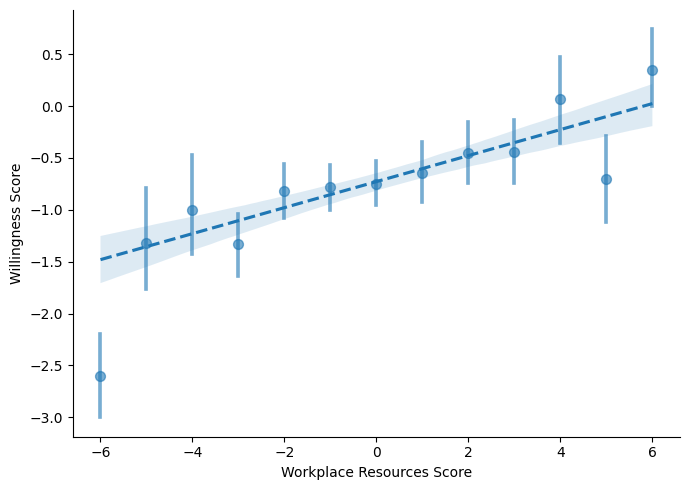

In [34]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ensure output directory exists
os.makedirs("figures", exist_ok=True)

xlabel = "Workplace Resources Score"
ylabel = "Willingness Score"

plt.figure(figsize=(7, 5))

reg = sns.regplot(
    x="workplace_resources",
    y="willingness",
    data=survey_coded,
    x_estimator=np.mean,
    scatter_kws={"alpha": 0.6},
    line_kws={"linestyle": "dashed"}
)

reg.set(xlabel=xlabel, ylabel=ylabel)
sns.despine()
plt.tight_layout()
plt.savefig("figures/resources_willingness_regplot.png")
plt.show()